# Prior Authorization Classifier

In this notebook, we survey various classifiers on different sets of features predicting whether a prior authorization, or PA, will get approved. According to our evaluations and comparison with the baseline model always predicting 1, we conclude that roc auc score is most suitable for selecting models. We see that a good choice of models for highest roc auc score are decision tree and random forest. With an analysis in [feature importances](./pa_classifier_feature_importances.ipynb), we decide that random forest is the best one. In the end, we add an appendix arguing why accuracy is not a good measure of models in this prior authorization classification problem.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
import dataframe_image as dfi
import upsetplot

sns.set_theme(style='whitegrid')

# import utils for loading data
# see `load_tables` in utils.py
import utils

## Load PA data

In [2]:
df_pa = utils.load_tables()['dim_pa_full']
df_pa.head(5)

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,417380,A,75,0,1.0,1,1,1,0,1,2017-01-01,2017,1,1,1,0,0,1
2,3,417740,A,76,0,2.0,1,1,0,0,1,2017-01-01,2017,1,1,1,0,0,1
9,10,417380,A,75,0,3.0,1,0,0,1,1,2017-01-01,2017,1,1,1,0,0,1
10,11,999001,A,76,0,4.0,1,1,1,0,1,2017-01-01,2017,1,1,1,0,0,1
14,15,417614,A,70,0,5.0,1,0,1,0,1,2017-01-01,2017,1,1,1,0,0,1


In [3]:
# split data

df_copy = df_pa.copy()

# a random feature is added for comparison of feature importances
df_copy['random'] = np.random.rand(df_copy.shape[0])

df_train_val = df_copy.sample(
    frac=0.8,
    random_state=614 # optional: use random_state for reproducibility
)

# test data
df_test = df_copy.drop(df_train_val.index)

# train data
df_train = df_train_val.sample(
    frac=0.9,
    random_state=614
)

# validation data
df_val = df_train_val.drop(df_train.index)

## Model Evaluations

The features we have for PA classification are `bin`, `drug`, `reject_code`, `correct_diagnosis`, `tried_and_failed` and `contraindication`. From our data exploration, `reject_code` for a fixed pair of (`bin`, `drug`) is also fixed. So we leave `reject_code` out in this section. We fit **Logistic Regression**, **Linear SVC**, **Decision Tree Classifier**, **Random Forest Classifier**, **Voting Classifier** and **AdaBoost Classifier** on all possible non-empty feature subsets. Note that we added a random feature to serve as a pivot. After fitting the model on the training data, we compute various scores of the model on the training, testing and validation data. 

After the evaluation, we can use the result to determine the best feature sets for models. We can also use it to compute the drop-feature importances, see [this notebook](./pa_classifier_feature_importances.ipynb) for details.

In [4]:
from sklearn.base import clone

# import models that we are going to fit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

# import scores to evaluate models
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# numerical columns of the dataframe (df_train and etc.) to use
# note that we added a column of random noise
num_cols = ['correct_diagnosis', 'tried_and_failed', 'contraindication', 'random']
# categorical columns of the dataframe to use
cat_cols = ['bin', 'drug']
# all feature columns
all_cols = cat_cols + num_cols

# set up the list of models to fit and evaluate
models = [
    ('Logistic', LogisticRegression()),
    ('SVC', LinearSVC(max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
]

vote = VotingClassifier(
    [
        ('Logistic', LogisticRegression()),
        ('SVC', LinearSVC(max_iter=10000)),
        ('Decision Tree', DecisionTreeClassifier()),
        ('Random Forest', RandomForestClassifier()),
    ],
    voting='hard'
)
models.append(('Voting', vote))

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
models.append(('AdaBoost', ada))

# set up the list of scores to evaluate models
score_funcs = [
    ('accuracy', accuracy_score),
    ('precision', precision_score),
    ('recall', recall_score),
    ('f1', f1_score),
    ('roc_auc', roc_auc_score),
]

# print out some info
print(f'There are {len(all_cols)} features:\n{all_cols}')
print()
print(f'Models to fit and evaluate: \n{[n for n, _ in models]}')
print()
print(f'Scores to evaluate models: \n{[s for s, _ in score_funcs]}')

There are 6 features:
['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication', 'random']

Models to fit and evaluate: 
['Logistic', 'SVC', 'Decision Tree', 'Random Forest', 'Voting', 'AdaBoost']

Scores to evaluate models: 
['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


Since we have 6 features, so we have a total of 63 non-empty feature subsets. We can number these subsets from 1 to 63.

In [5]:
def get_features(fid):
    '''Get the feature subset from the fid between 1 and 63.
    '''
    fin_bin = [(fid >> i) & 1 for i in range(len(all_cols))]
    feats = [f for b, f in zip(fin_bin, all_cols) if b]
    num_feats = [f for f in feats if f in num_cols]
    cat_feats = [f for f in feats if f in cat_cols]
    return num_feats, cat_feats, feats

def save_evaluate_data(data, path=None):
    '''Save evaluation data to a csv file.
    
    The csv file will have 5 columns:
        - fid: a number to identify the feature subset
        - model: name of the model in evaluation
        - data_type: one of {'train', 'test', 'validation'} indicating which
            dataset is used to evaluate the model
        - score_func: name of the scoring function
        - score: acutal score of the evaluation
    
    Args:
        data (list): each element is a list of 5 items, one for each column
        path (str, optional): path to save the csv file
    '''
    df_models = pd.DataFrame(
        data=data,
        columns=['fid', 'model', 'data_type', 'score_func', 'score']
    )
    if path:
        df_models.to_csv(path, index=False)
    return df_models

In [6]:
subsets = []
for fid in range(2 ** len(all_cols)):
    fid_bin = [(fid >> i) & 1 for i in range(len(all_cols))]
    subsets.append(fid_bin)

df_features = pd.DataFrame(
    data=subsets, columns=all_cols
).reset_index().rename(columns={'index': 'fid'})

df_features.head(5)

,fid,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0
2,2,0,1,0,0,0,0
3,3,1,1,0,0,0,0
4,4,0,0,1,0,0,0


In [7]:
get_features(3)[2]

['bin', 'drug']

The dataframe `df_features` lists all subset of features with index being their `fid`s, compatible with `get_features`. For example, `get_features(3)[2] = ['bin', 'drug']` and `df_features` has `bin` and `drug` set to 1 at when `fid = 3`.

In [8]:
# the return of evaluate_model will be elements in the data argument
# in the save_evaluation_data function above
def evaluate_model(fid, model, name, X, y, data_type, score_name, score_func):
    y_pred = model.predict(X)
    score = score_func(y, y_pred)
    return (fid, name, data_type, score_name, score)

# get the target variables
y_train = df_train.pa_approved.to_numpy()
y_val = df_val.pa_approved.to_numpy()
y_test = df_test.pa_approved.to_numpy()

# each worker evaluate all models with all scores on a given set of features
def worker(fid):
    num_feats, cat_feats, _ = get_features(fid)
    # utils.DataFrameFeatures extract columns of a dataframe to form input.
    # It converts categorical columns into one hot encoding.
    feat_map = utils.DataFrameFeatures(
        num_cols=num_feats, cat_cols=cat_feats
    ).fit(df_copy)
    
    X_train = feat_map.transform(df_train)
    X_val = feat_map.transform(df_val)
    X_test = feat_map.transform(df_test)
    
    f_data = []
    for m_name, m in models:
        # fit the model of training data
        model = clone(m).fit(X_train, y_train)
        
        # evaluate the fitted model on various scoring functions
        for s in score_funcs:
            # on training data
            item = evaluate_model(
                fid, model, m_name,
                X_train, y_train, 'train',
                *s
            )
            f_data.append(item)
            
            # on validation data
            item = evaluate_model(
                fid, model, m_name,
                X_val, y_val, 'validation',
                *s
            )
            f_data.append(item)
            
            # on testing data
            item = evaluate_model(
                fid, model, m_name,
                X_test, y_test, 'test',
                *s
            )
            f_data.append(item)
            
    return f_data

In [9]:
import os
import multiprocessing

# It takes couple of hours to evaluate all models, so it is a good idea to
# save previously computed result. We provided our computed result in the
# csv file named model_evals.csv in the data folder.
_DEFAULT_EVAL_PATH = os.path.join(utils.DATA_FOLDER, 'model_evals.csv')
def get_model_evaluation(path=_DEFAULT_EVAL_PATH):
    if os.path.exists(path):
        return pd.read_csv(path)
    
    map_data = []
    # use multiple processes to accerlate the evaluation
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        map_data = pool.map(worker, range(1, 64))
    
    data = []
    for d in map_data:
        data.extend(d)
    
    return save_evaluate_data(data, path)

df_evals = get_model_evaluation()
df_evals.head(5)

,fid,model,data_type,score_func,score
0,0,Baseline,train,accuracy,0.734337
1,0,Baseline,train,precision,0.734337
2,0,Baseline,train,recall,1.000000
3,0,Baseline,train,f1,0.846821
4,0,Baseline,train,roc_auc,0.500000


Results of the evaluations are stored in `df_evals`. We can decide what is the best feature set for a model under a particular scoring function.

In [10]:
df_temp = (
    df_evals
    .groupby(['model', 'data_type', 'score_func'])
    .agg({'score': 'max'})
    .reset_index()
)

df_temp = pd.merge(
    df_temp, df_evals,
    on=['model', 'data_type', 'score_func', 'score'],
    how='left'
)

df_best_evals = pd.merge(
    df_temp, df_features, on='fid', how='left'
)

# get models we are intersted in for now
df_best_evals = df_best_evals[
    ~df_best_evals.model.isin(['Bayes'])
]

df_best_evals.head(5)

,model,data_type,score_func,score,fid,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
0,AdaBoost,test,accuracy,0.769251,19,1,1,0,0,1,0
1,AdaBoost,test,f1,0.859208,19,1,1,0,0,1,0
2,AdaBoost,test,precision,0.778830,19,1,1,0,0,1,0
3,AdaBoost,test,recall,1.000000,1,1,0,0,0,0,0
4,AdaBoost,test,recall,1.000000,2,0,1,0,0,0,0


The second row in the table means that for the **AdaBoost Classifier** evaluated on the test data using **f1 score**, the best feature subset is [`bin`, `drug`], which scores 0.859208. Can we say that the **AdaBoost Classifier** is a good model for our problem? To answer this question, we need to compare its f1 score to that of some baseline model.

### The Baseline Model

Recall from the [data exploration](./exploration.ipynb) that the target rate, or the overall PA approved rate, is 73.45%. We should look at the scores of the baseline model that always predicts 1.

In [11]:
df_baseline = df_evals[df_evals.model == 'Baseline']
if df_baseline.shape[0] == 0:
    data = []
    for data_type, y_true in [('train', y_train), ('test', y_test), ('validation', y_val)]:
        y_pred = np.ones_like(y_true)
        for name, func in score_funcs:
            s = func(y_true, y_pred)
            data.append([0, 'Baseline', data_type, name, s])

    df_baseline = save_evaluate_data(data)
    df_evals = pd.concat([df_baseline, df_evals], axis=0)
    df_evals.to_csv(_DEFAULT_EVAL_PATH, index=False)
df_baseline

,fid,model,data_type,score_func,score
0,0,Baseline,train,accuracy,0.734337
1,0,Baseline,train,precision,0.734337
2,0,Baseline,train,recall,1.000000
3,0,Baseline,train,f1,0.846821
4,0,Baseline,train,roc_auc,0.500000
5,0,Baseline,test,accuracy,0.734895
6,0,Baseline,test,precision,0.734895
7,0,Baseline,test,recall,1.000000
8,0,Baseline,test,f1,0.847193
9,0,Baseline,test,roc_auc,0.500000


Take a look at the row with index 8 above, the f1 score for the Baseline model on the test set is 0.847193. Compared to 0.859208 for the AdaBoost classifier, we see that it is not convincing to conclude AdaBoost classifier is good.

We notice that the roc auc scores for the baseline model on all data sets are 0.5, so it is essentially a random classifier. All other scores are relatively high, so it is better to use roc auc scores to select the best model. In the end of the notebook, we argue in details why accuracy is not a good measure of models in this classification problem.

**Note: In binary classifications, roc auc score is the average of true positive rate and true negative rate.**

In [12]:
# we look at the models with best roc auc scores at validation set
fil = (df_best_evals.score_func == 'roc_auc') & (df_best_evals.data_type == 'validation')
df_best_roc_auc = df_best_evals[fil].sort_values('score', ascending=False)

df_best_roc_auc

,model,data_type,score_func,score,fid,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
414,Decision Tree,validation,roc_auc,0.752150,15,1,1,1,1,0,0
570,Random Forest,validation,roc_auc,0.752150,15,1,1,1,1,0,0
741,Voting,validation,roc_auc,0.749010,15,1,1,1,1,0,0
518,Logistic,validation,roc_auc,0.606872,23,1,1,1,0,1,0
519,Logistic,validation,roc_auc,0.606872,55,1,1,1,0,1,1
77,AdaBoost,validation,roc_auc,0.603134,19,1,1,0,0,1,0
686,SVC,validation,roc_auc,0.577263,29,1,0,1,1,1,0
687,SVC,validation,roc_auc,0.577263,61,1,0,1,1,1,1
92,Baseline,validation,roc_auc,0.500000,0,0,0,0,0,0,0


The top 3 classifiers has close roc auc scores to 0.75, all modelled on the feature sets [`bin`, `drug`, `correct_diagnosis`, `tried_and_failed`]. They are aware that feature `random` is useless, which is good. However, it is surprising to see that they all decide that feature `contraindication` is not good for them when targeting at best roc auc scores.

We now put these all models with highest roc auc scores side by side with the baseline model so that we can compare them using all availabel scores.

In [13]:
def transform_helper(df):
    ret = df.score.to_frame()
    ret.index = df.score_func
    ret = ret.transpose()
    ret['model'] = df.model.iloc[0]
    ret = ret.set_index('model')
    return ret

df_baseline_val_scores = transform_helper(df_baseline[df_baseline.data_type == 'validation'])
dataframes = []

# models with hightest roc auc scores
for model in df_best_evals.model.unique():
    fid = df_best_roc_auc[df_best_roc_auc.model == model].fid.iloc[0]
    df_temp = df_evals[
        (df_evals.model == model) & (df_evals.fid == fid) & (df_evals.data_type == 'validation')
    ]
    dataframes.append(transform_helper(df_temp))

df_roc_auc_top = pd.concat(dataframes, axis=0).sort_values('roc_auc', ascending=False)
df_roc_auc_top_styled = df_roc_auc_top.style.background_gradient(axis=0)
dfi.export(df_roc_auc_top_styled, 'images/models_comparison_roc_auc.png')

df_roc_auc_top_styled

score_func,accuracy,precision,recall,f1,roc_auc
model,,,,,
Decision Tree,0.784086,0.877707,0.820280,0.848023,0.752150
Random Forest,0.784086,0.877707,0.820280,0.848023,0.752150
Voting,0.760073,0.886092,0.772610,0.825469,0.749010
Logistic,0.768302,0.780987,0.951258,0.857754,0.606872
AdaBoost,0.770033,0.778863,0.959188,0.859671,0.603134
SVC,0.752271,0.767514,0.950615,0.849308,0.577263
Baseline,0.734374,0.734374,1.000000,0.846846,0.500000


We highlighted the maximum score in each column. Decision tree and random forest performs similarly on this dataset. F1 score is the geometric average of precision and recall, and roc auc score is the average of true positive rate and true negative rate. They are both good measures in practice. **As it turns out, decision tree, random forest and voting classifier are still the top 3 models with respect to the f1 scores.**

We have a tie here for decision tree and random forest, no matter what scoring functions we look at. We can not confirmatively decide which one to use by just looking at the scores. Using feature importances as in [this notebook](./pa_classifier_feature_importances.ipynb), we can determine that random forest is better than decision tree. 

## Fine Tuning

In this section, we show two ways of fine tuning models. One way is to fine tune models' parameters using cross validation, and the other is to find tune models' feature sets. The second method is different from the previous models evaluation in the following way. For categorical features such as `bin`, we do one-hot encoding. `bin` has 4 categories, say, A, B, C, D. Then one-hot encoding gives us 3 new related binary features `bin_A`, `bin_B` and `bin_C`. Fine tuning the feature sets here means we might leave out some of the binary features from the same categorical features.

One note is that, we will include back the `reject_code` feature, as leaving out some binary features from the same categorical features might lose information about the dataset.

### Fine tuning the features

In [14]:
feat_map = utils.DataFrameFeatures(
    num_cols=['correct_diagnosis', 'tried_and_failed', 'contraindication'],
    cat_cols = ['bin', 'drug', 'reject_code']
)
feat_map.fit(df_pa)
feature_set = feat_map.feature_names_
n_feat = len(feature_set)

print(f'{n_feat} available features:\n{feature_set}')

10 available features:
['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin_417380', 'bin_417614', 'bin_417740', 'drug_A', 'drug_B', 'reject_code_70', 'reject_code_75']


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# set up training set for `fine_tune_feature_set`
X_ft = feat_map.transform(df_pa)
y_ft = df_pa.pa_approved.to_numpy()

X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(
    X_ft, y_ft,
    test_size=0.2,
    stratify=y_ft,
    random_state=614 # for reproducibility
)

def convert_num_to_bin(n, l):
    return [(n >> i) & 1 for i in range(l)]

def get_feature_subset(n, feature_set):
    bits = convert_num_to_bin(n, len(feature_set))
    return [f for f, b in zip(feature_set, bits) if b]
    

def fine_tune_feature_set(model, model_id, splits=5):
    # cache and reuse result as it takes a long time to run
    path = os.path.join(
        utils.DATA_FOLDER,
        f'{model_id}_fine_tune_feature_set.csv'
    )
    if os.path.exists(path):
        return pd.read_csv(path)

    kfold = StratifiedKFold(n_splits=splits)
    
    # set up arrays to store scores
    n_feat_sets = 2 ** n_feat
    scores = {}
    for name, _ in score_funcs:
        scores[name] = np.zeros((splits, n_feat_sets))
    
    # cross validation loop
    for i, (train_idx, test_idx) in enumerate(kfold.split(X_ft_train, y_ft_train)):
        X_train, X_val = X_ft_train[train_idx], X_ft_train[test_idx]
        y_train, y_val = y_ft_train[train_idx], y_ft_train[test_idx]
        for j in range(1, n_feat_sets):
            mask = convert_num_to_bin(j, n_feat)
            mask = [i for i, m in zip(range(n_feat), mask) if m]
            model_clone = clone(model).fit(X_train[:, mask], y_train)
            y_pred = model_clone.predict(X_val[:, mask])
            for name, func in score_funcs:
                scores[name][i, j] = func(y_val, y_pred)
    
    # save result to dataframe
    # columns: fid (feature set id), score_name, score_mean, score_std
    dataframes = []
    for key, val in scores.items():
        score_mean = np.mean(val, axis=0)
        score_std = np.std(val, axis=0)
        df = pd.DataFrame({
            'fid': np.arange(n_feat_sets),
            'score_func': key,
            'score_mean': score_mean,
            'score_std': score_std
        })
        dataframes.append(df)
    
    df = pd.concat(dataframes, ignore_index=True)
    df.to_csv(path, index=False)
    return df

We run logistic regression against all possible non-empty feature sets, and store evaluations into `df_ft_log`.

In [16]:
df_ft_log = fine_tune_feature_set(LogisticRegression(), 'log_clf')

df_ft_log.head(5)

,fid,score_func,score_mean,score_std
0,0,accuracy,0.000000,0.0
1,1,accuracy,0.734452,0.0
2,2,accuracy,0.734452,0.0
3,3,accuracy,0.734452,0.0
4,4,accuracy,0.734452,0.0


For each scoring function, we will find the best feature sets for it. There could be multiple feature sets best for some scoring functions. 

In [17]:
df_temp = (
    df_ft_log
    .groupby(['score_func'])
    .agg({'score_mean': 'max'})
    .reset_index()
)

df_ft_log_best = pd.merge(
    df_temp, df_ft_log,
    on=['score_func', 'score_mean'],
    how='left'
)

df_ft_log_best.head()

,score_func,score_mean,fid,score_std
0,accuracy,0.814388,1015,0.000763
1,f1,0.880283,278,0.000323
2,f1,0.880283,302,0.000323
3,f1,0.880283,326,0.000323
4,f1,0.880283,342,0.000323


`df_ft_log_best` list best `fid` for each score. In the above table, we see that for f1 score, there are multiple festure sets achieving the best score. 

In [18]:
acc_fid = df_ft_log_best[df_ft_log_best.score_func == 'accuracy'].fid.iloc[0]

log_best_accuracy_set = get_feature_subset(fid, feature_set)
print('The best set of parameters for logistic regression to get higheset accuracy:')
print(log_best_accuracy_set)

The best set of parameters for logistic regression to get higheset accuracy:
['correct_diagnosis', 'tried_and_failed', 'contraindication', 'bin_417380']


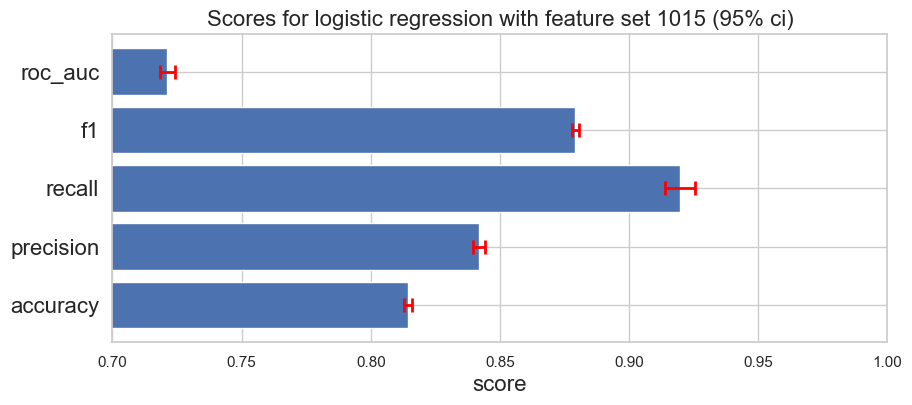

In [19]:
# Take a look at another scores when accuracy is highest

df_temp = df_ft_log[df_ft_log.fid == acc_fid]

plt.figure(figsize=(10, 4))
plt.barh(
    range(df_temp.shape[0]),
    df_temp.score_mean,
    xerr=df_temp.score_std * 2,
    align='center',
    ecolor='red',
    error_kw=dict(lw=2, capsize=5, capthick=2)
)
plt.yticks(range(df_temp.shape[0]), df_temp.score_func, fontsize=16)
plt.xlim([0.7, 1])
plt.xlabel('score', fontsize=16)

plt.title(
    f'Scores for logistic regression with feature set {acc_fid} (95% ci)',
    fontsize=16
)

plt.show()

We care about roc auc scores of models. Let's compare the fined tuned logistic regression to models in the previous section.

In [20]:
# find the best fine tuned logistic regression on roc auc
roc_fid1 = df_ft_log_best[df_ft_log_best.score_func == 'roc_auc'].fid.iloc[0]
df_temp1 = df_ft_log[df_ft_log.fid == roc_fid1].copy()
df_temp1 = df_temp1.rename(columns={'score_mean': 'score'})
df_temp1['model'] = 'Fine tuned Logistic'
df_temp1 = transform_helper(df_temp1)

# throw in also the best models for roc auc for comparison
pd.concat([df_temp1, df_roc_auc_top], axis=0).sort_values('roc_auc', ascending=False)

score_func,accuracy,precision,recall,f1,roc_auc
model,,,,,
Fine tuned Logistic,0.735462,0.930147,0.691770,0.793438,0.774038
Decision Tree,0.784086,0.877707,0.820280,0.848023,0.752150
Random Forest,0.784086,0.877707,0.820280,0.848023,0.752150
Voting,0.760073,0.886092,0.772610,0.825469,0.749010
Logistic,0.768302,0.780987,0.951258,0.857754,0.606872
AdaBoost,0.770033,0.778863,0.959188,0.859671,0.603134
SVC,0.752271,0.767514,0.950615,0.849308,0.577263
Baseline,0.734374,0.734374,1.000000,0.846846,0.500000


The fine tuned logistic regression on roc auc score has the best roc auc scores among the all models listed. It has the best precision as well. However, its f1 score is even worse than the baseline model, because it has an extremely low recall. Though the fine tuned logistic regression has the best roc auc score, we will not use it as its f1 score is even worse than the baseline model.

### Fine tuning parameters

We are going to fine tune models' parameters. We focus on the random forest model we found in the Model Evaluation section with the best roc auc score.

In [21]:
# remind ourselves the best random forest model
fil = (df_best_evals.score_func == 'roc_auc') & (df_best_evals.data_type == 'validation')
fil = fil & (df_best_evals.model.isin(['Random Forest', 'Decision Tree']))
df_best_evals[fil]

,model,data_type,score_func,score,fid,bin,drug,correct_diagnosis,tried_and_failed,contraindication,random
414,Decision Tree,validation,roc_auc,0.75215,15,1,1,1,1,0,0
570,Random Forest,validation,roc_auc,0.75215,15,1,1,1,1,0,0


The best feature set for decision tree and random forest is [`bin`, `drug`, `correct_diagnosis`, `tried_and_failed`] with the best roc auc score being 0.75215. We are going to tune parameters for random forest to improve the performance.

In [22]:
# set up training set for `fine_tune_feature_set`
feat_map = utils.DataFrameFeatures(
    num_cols=['correct_diagnosis', 'tried_and_failed'],
    cat_cols = ['bin', 'drug']
)
feat_map.fit(df_pa)

X_ft_train = feat_map.transform(df_train)
y_ft_train = df_train.pa_approved.to_numpy()
X_ft_test = feat_map.transform(df_test)
y_ft_test = df_test.pa_approved.to_numpy()
X_ft_val = feat_map.transform(df_val)
y_ft_val = df_val.pa_approved.to_numpy()

Doing a grid search of parameters for random forest takes a long time. Our strategy is to fine tune parameters for decision tree first, then use these tuned parameters for random forest.

In [23]:
from sklearn.model_selection import GridSearchCV

#### Decision Tree

In [24]:
dtc_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid={
        'criterion': ['gini', 'entropy'],
        'max_depth': range(5, 16),
        'min_samples_split': range(2, 7)
    },
    scoring='roc_auc',
    n_jobs=-1,
).fit(X_ft_train, y_ft_train)

print('The best parameters for decision tree:')
print(dtc_search.best_params_)

The best parameters for decision tree:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2}


In [26]:
dtc = DecisionTreeClassifier(**dtc_search.best_params_).fit(X_ft_train, y_ft_train)
y_pred = dtc.predict(X_ft_val)
dtc_roc = roc_auc_score(y_ft_val, y_pred)
print(f'roc auc score for tuned decision tree: {dtc_roc:.5f}')

roc auc score for tuned decision tree: 0.75215


#### Random Forest

In [27]:
rfc_search = GridSearchCV(
    RandomForestClassifier(**dtc_search.best_params_, random_state=614),
    param_grid={
        'n_estimators': range(11, 21)
    },
    scoring='roc_auc',
    n_jobs=-1,
).fit(X_ft_train, y_ft_train)

print('The best parameters for random forest:')
print(dtc_search.best_params_ | rfc_search.best_params_)

The best parameters for random forest:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 15}


In [28]:
rfc = RandomForestClassifier(
    **dtc_search.best_params_, **rfc_search.best_params_, random_state=614
).fit(X_ft_train, y_ft_train)

y_pred = rfc.predict(X_ft_val)
dtc_roc = roc_auc_score(y_ft_val, y_pred)
print(f'roc auc score for tuned random forest: {dtc_roc:.5f}')

roc auc score for tuned random forest: 0.75215


Unfortunately, we don't see improvement roc auc score. We guess the reason to be that the default parameters are already the best for the random forest model in this particular classification problem.

## A web app

We create a web app based on the random forest classifier, available at [https://pachecker.herokuapp.com](https://pachecker.herokuapp.com).

This app is very valuable to patients and doctors. Before patients rush to pharmacies to get their prescriptions, they can use this app to check whether they need a prior authorization, and learn the chance of the prior authorization getting approved. It can potentially help patients get the treatment they need quicker.

When doctors prescribe treatments for patients, they can use this app to check whether the patients need prior authorizaitons to get their treatments. If a prior authorization is needed, the doctors can see clearly the probability of the PA getting approved. If it is unlikely to have the PA approved, the doctor can immediately adjust the treatment for the patients.

![Example of unlikely PA approval](images/screenshot_of_webapp_result.png)

For example, the above result from the web app indicates that drug C for payer 417380 is unlikely approved for patients that don't have the correct diagnosis for drug C and have not tried and failed other treatments, but has an associated contraindication for the medication requested. When the doctors see this result, they could replace drug C by an alternative one.

It makes the process of treatment more efficient. Doctors save time, patients save lives!

## Appendix: The Bayes Optimal Predictor

In this appendix, we argue why accuracy is not a good measure for our models.

Let $\mathcal{X}$ be the feature space. Given any probability distribution $\mathcal{D}$ over $\mathcal{X} \times \{0, 1\}$, a classification problem is to come up with a classifier $h: \mathcal{X} \to \{0, 1\}$ to minimize some loss function, for example:
$$L_{\mathcal{D}}(h) = \mathbb{E}_{(x, y) \sim \mathcal{D}} (h(x) - y)^2.$$
This loss function is actually the error rate, or 1 - accuracy. So to minimize this loss function is the same as to maximize accuracy.

Claim: The best classifier from $\mathcal{X}$ to $\{0, 1\}$ will be
$$f_{\mathcal{D}}(x) = \left\{
    \begin{array}{ll}
        1 & \text{ if }P(y=1|x) \ge \frac{1}{2} \\
        0 & \text{ otherwise.}
    \end{array}
\right.$$
This $f_{\mathcal{D}}$ is the **Bayes Optimal Predictor** with respect to $D$.

*Proof.* Let $g: \mathcal{X} \to \{0, 1\}$ be any classifier. We need to show $L_{\mathcal{D}}(f_{\mathcal{D}}) \le L_{\mathcal{D}}(g)$. For $x \in \mathcal{X}$, let $\alpha_x$ be the conditional probability of $y=1$, that is,
$$\alpha_x = P(y=1|x).$$
Then,
$$\begin{split}
    P(f_\mathcal{D}(x) \ne y|x) &= \left\{
        \begin{array}{ll}
            P(y=0|x) & \text{ if } \alpha_x \ge \frac{1}{2} \\
            P(y=1|x) & \text{ if } \alpha_x < \frac{1}{2}.
        \end{array}
    \right.\\
    &= \left\{
        \begin{array}{ll}
            1 - \alpha_x & \text{ if } \alpha_x \ge \frac{1}{2} \\
            \alpha_x & \text{ if } \alpha_x < \frac{1}{2}.
        \end{array}
    \right.\\
    &= \min(\alpha_x, 1 - \alpha_x)
\end{split}$$

And,
$$\begin{split}
    P(g(x) \ne y | x) &= P(g(x)=0|x)P(y=1|x) + P(g(x)=1|x)P(y=0|x) \\
    &= P(g(x)=0|x) \alpha_x + P(g(x)=1|x) (1 - \alpha_x) \\
    &\ge \left(P(g(x)=0|x) + P(g(x)=1|x)\right) \min(\alpha_x, 1-\alpha_x) \\
    &= \min(\alpha_x, 1-\alpha_x).
\end{split}$$

Therefore, for each $x \in \mathcal{X}$,
$$P(f_\mathcal{D}(x) \ne y|x) \le P(g(x) \ne y|x).$$
So $L_{\mathcal{D}}(f_{\mathcal{D}}) \le L_{\mathcal{D}}(g)$. $\blacksquare$

In our classification of PA approval or acceptance, the feature space is a finite set. Feature `bin` has 4 possible values, `drug` has 3, while  `correct_diagnosis`, `tried_and_failed` and `contraindication` are binary. So the feature space has $4 \times 3 \times 2^3 = 96$ points. We have half a million data points, so the empirical distribution gives a good estimate of the true distribution $D$. Thus, we have a empirical Bayes optimal predictor in regard to accuracy.

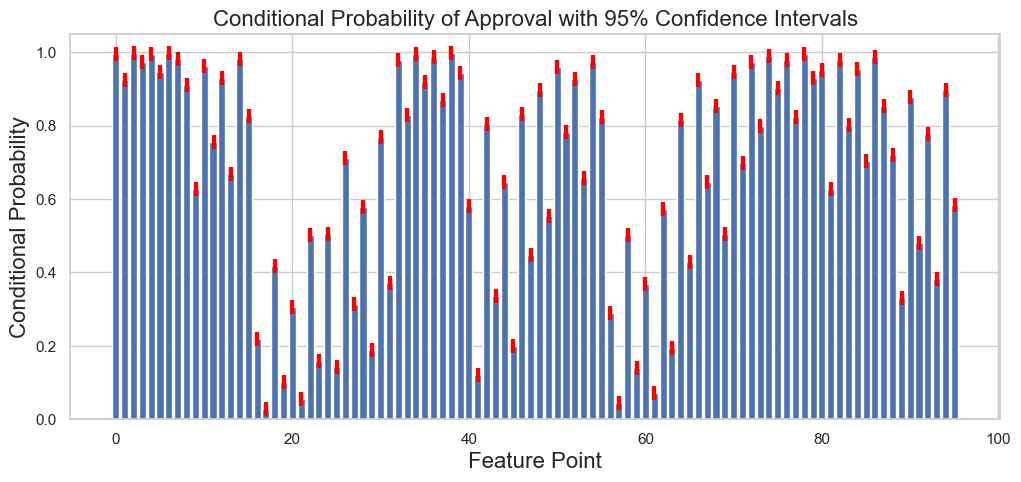

In [29]:
from scipy.stats import bayes_mvs

def mean_conf_int(data):
    result = bayes_mvs(data, alpha=0.95)
    return result[0]

all_feats = ['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication']
cond_proba = (
    df_pa[all_feats + ['pa_approved']]
    .groupby(all_feats)
    .apply(mean_conf_int)
    .tolist()
)

means = [x.statistic for x in cond_proba]
err_bars = [
    [x.minmax[0] - x.statistic for x in cond_proba],
    [x.minmax[1] - x.statistic for x in cond_proba]
]

plt.figure(figsize=(12, 5))
plt.bar(
    range(len(means)), means,
    xerr=err_bars, ecolor='red',
    error_kw=dict(capsize=5, capthick=3)
)
plt.xlabel('Feature Point', fontsize=16)
plt.ylabel('Conditional Probability', fontsize=16)
plt.title('Conditional Probability of Approval with 95% Confidence Intervals', fontsize=16)
plt.show()

The conditional probability, or the $\alpha_x$ in the proof of the claim above, can be well estimated from this dataset. We are going to compute the empirical Bayes optimal predictor from the training data, and the evaluate various scores for it.

In [30]:
class BayesOptimalPredictor:
    
    def __init__(self,
                 features=['bin', 'drug', 'correct_diagnosis', 'tried_and_failed', 'contraindication']):
        self.features = features
    
    def fit(self, X, y=None):
        self.predictions_ = {}
        df = (
            X
            .groupby(self.features)
            .agg(rate=('pa_approved', lambda s: s.sum() / s.count()))
        )
        for f, r in zip(df.index, df.rate):
            if type(f) is not tuple:
                f = (f, )
            self.predictions_[f] = int(r > 0.5)
        return self
    
    def predict(self, X):
        y = X.apply(self._predict_row, axis=1)
        return y.to_numpy()
    
    def _predict_row(self, row):
        t = tuple(getattr(row, f) for f in self.features)
        return self.predictions_.get(t, 1)


df_bayes = df_evals[df_evals.model == 'Bayes']
if df_bayes.shape[0] == 0:
    data = []
    for fid in range(1, 64):
        _, _, feats = get_features(fid)
        bop = BayesOptimalPredictor(feats).fit(df_train)
        for dt, X in [('train', df_train), ('test', df_test), ('validation', df_val)]:
            y_pred = bop.predict(X)
            y_true = X.pa_approved.to_numpy()
            for name, func in score_funcs:
                s = func(y_true, y_pred)
                data.append([fid, 'Bayes', dt, name, s])
    
    df_bayes = save_evaluate_data(data)
    df_evals = pd.concat([df_evals, df_bayes], axis=0)
    df_evals.to_csv(_DEFAULT_EVAL_PATH, index=False)

df_bayes = df_bayes[df_bayes.fid == 31]
df_bayes

,fid,model,data_type,score_func,score
6135,31,Bayes,train,accuracy,0.814005
6136,31,Bayes,train,precision,0.834339
6137,31,Bayes,train,recall,0.931711
6138,31,Bayes,train,f1,0.880341
6139,31,Bayes,train,roc_auc,0.710178
6140,31,Bayes,test,accuracy,0.813868
6141,31,Bayes,test,precision,0.834710
6142,31,Bayes,test,recall,0.931100
6143,31,Bayes,test,f1,0.880274
6144,31,Bayes,test,roc_auc,0.709995


Let's compare the Bayes optimal predictor to the models (modeled on the same feature set as in the Bayes optimal predictor, i.e., `fid = 31`) in Model Evaluations section.

In [31]:
dataframes = []
for model in df_evals.model.unique():
    fid = 31 if model != 'Baseline' else 0
    df_temp = df_evals[
        (df_evals.data_type == 'validation') & (df_evals.model == model) \
        & (df_evals.fid == fid)
    ]
    dataframes.append(transform_helper(df_temp))

df_best_acc = pd.concat(dataframes, axis=0)
df_best_acc.sort_values('accuracy', ascending=False)

score_func,accuracy,precision,recall,f1,roc_auc
model,,,,,
Decision Tree,0.816215,0.836762,0.931449,0.881571,0.714540
Random Forest,0.816215,0.836762,0.931449,0.881571,0.714540
Bayes,0.816215,0.836762,0.931449,0.881571,0.714540
Voting,0.797509,0.838698,0.896730,0.866744,0.709961
SVC,0.750022,0.765949,0.949850,0.848044,0.573706
Logistic,0.749550,0.765959,0.948901,0.847672,0.573655
Baseline,0.734374,0.734374,1.000000,0.846846,0.500000
AdaBoost,0.729674,0.763474,0.915529,0.832616,0.565687


The Bayes optimal predictor is indeed the best in accuracy. Decision tree and random forest can do as good as the Bayes optimal predictor. It shows that if we care only about accuracy, the Bayes optimal predictor should be the choice. The accuracy score is not a good measure of models in this classification problem, as it limits us to the Bayes optimal predictor, and lose flexibility in other scores as the Bayes optimal predictor has no parameters to train. 